In [1]:
unicode = str

from igor.binarywave import load
from scipy.signal import detrend
from skimage import feature
from skimage import transform
import io
import numpy as np
import pandas as pd
import h5py
import os

def load_ibw(path, flatten=True):
    """
    Given a path to an Igor Binary Wave, return the image file as a 3 dimensional 
    numpy array.
    
    Input:
        path: string file path to .ibw file
        flatten (optional): boolean input to flatten topography data.
    Output:
        data: 3 dimensional numpy array containing .ibw data.
    """
    data = load(path)['wave']['wData']

    # Flatten the topography data by extracting any linear response.
    if flatten == True:   
        flat_topo = data.copy()
        flat_topo[:, :, 0] = detrend(flat_topo[:, :, 0])
        data = flat_topo
        
    data = np.rot90(data)    
    return data

def hyperslice(hyper, start, stop, rows = None , cols = None):
    """
    Sums a range of wavenumbers within a hyperspectral image. 
    
    Paramters 
    ----------
        hyper: class from HyperImage
        start: int
            start wavenumber
        stop: int
            stop wavenumber
        rows: tuple, (start, stop)
    	    starting and ending indices for rows within image 
            be displayed. If all rows are desired, can 
            leave blank.  
        cols: tuple, (start, stop)
            same as above, but for columns. 
    Returns
    -------
        slc: ndarray
            sum of intensities between the specified start and
            stop wavenumbers 
        
    """
    #show entire hyper image if no tuples are passed into arguments
    if rows == None: 
        rows = (0,hyper.channel_data.shape[0])
    if cols == None:
        cols = (0, hyper.channel_data.shape[1])        

    wavenumber = hyper.wavelength_data.tolist()
    wavenumberlist = [int(x) for x in wavenumber]
    #flip start and stop indices because of the 
    #way the wavenumber data is stored. 
    start_index = wavenumberlist.index(stop)
    stop_index = wavenumberlist.index(start) 
    span = stop_index - start_index
    slc = hyper.hyper_image[rows[0]:rows[1],cols[0]:cols[1],start_index]
    for i in range(span):
        slc += hyper.hyper_image[rows[0]:rows[1],cols[0]:cols[1],start_index+i]
    
    return slc
    
    

class HyperImage():
    """
    A class representing a Hyper image. Give the path to the Hyper data,
    and receive a class that stores this information as a hyper image,
    and series of channel images.
    """
    def __init__(self, path):
        
        self.wavelength_data = None
        self.channel_names = []
        full_path = os.path.realpath(path)
        directory = os.path.dirname(full_path)
        
        # Get the scan parameters and channel details.
        self.parms, channels, e =  read_anfatec_params(full_path)
        
        x_pixel = int(self.parms['xPixel'])
        y_pixel = int(self.parms['yPixel'])
        
        self.wavelength_data = np.loadtxt(os.path.join(directory,str(channels[0]['FileNameWavelengths'])))
        wavenumber_length = self.wavelength_data.shape[0] 
        image_shape = (x_pixel,y_pixel,wavenumber_length)

        hyper_image = np.zeros(image_shape)
        
        # This scales the integer data into floats.
        pifm_scaling = float(channels[0]['Scale'])
        
        # Read the Raw Hyper data from the bitfile.
        data = np.fromfile(os.path.join(directory,channels[0]['FileName']),dtype='i4')
        for i,line in enumerate(np.split(data,y_pixel)):
            for j, pixel in enumerate(np.split(line,x_pixel)):
                    hyper_image[j,i,:] = pifm_scaling*pixel
                    
        # Put all the different channels into one big array.
        channel_data = np.zeros((x_pixel, y_pixel, len(channels[1:])))
        for ch, channel in enumerate(channels[1:]):
            self.channel_names.append(channel['Caption'])
            data = np.fromfile(os.path.join(directory,channel['FileName']),dtype='i4')
            scaling = float(channel['Scale'])

            for i,line in enumerate(np.split(data,y_pixel)):
                for j, pixel in enumerate(np.split(line,x_pixel)):
                        channel_data[j,i,ch] = (scaling*pixel)

        # Here's how we access the different hyper and channel data.
        self.hyper_image = np.rot90(hyper_image, k=-1)
        self.channel_data = np.rot90(channel_data, k=-1)
        
        self.hyper_image = self.hyper_image[:,::-1,:]
        self.channel_data = self.channel_data[:,::-1,:]
        

class PiFMImage():
    """
    A class representing a PiFM image. Give the path to the PiFM data
    and receive a class that stores this information as a hyper image, 
    and series of channel images.
    
    Input: 
        path: Path to ANFATEC parameter file. This is the text file that
        is generated with each scan.
        
    Attributes: 
        channel_names: list of all data channels in channel_data 
        channel_data: a resolution x resolution x no. channel array. 
                    channel_data[:,:,0] will return the matrix 
                    corresponding to the channel in channel_names[0]
        parms: a dictionary of all scan parameters 
        spectra_files: list of filenames containing point spectra 
        point_spectra: list of df containing point spectra associated 
                        with scan. point_spectra[0] will return the df
                        corresponding to the file in spectra_file[0]
                    
    """
    def __init__(self, path):
        
        
        self.channel_names = []
        self.spectra_files = []
        full_path = os.path.realpath(path)
        directory = os.path.dirname(full_path)
        
        # Get the scan parameters and channel details.
        self.parms, channels, spectra =  read_anfatec_params(full_path)
       
        x_pixel = int(self.parms['xPixel'])
        y_pixel = int(self.parms['yPixel'])
        
        #Make one big array for all the data channels.
        channel_data = np.zeros((x_pixel, y_pixel, len(channels)))
        for i, channel in enumerate(channels):
            
            self.channel_names.append(channel['Caption'])
            data = np.fromfile(os.path.join(directory,channel['FileName']),\
                               dtype='i4')
            #scaling = float(channel['Scale'])
            channel_data[:,:,i] = np.reshape(data, (256,256))
            
            #for i,line in enumerate(np.split(data,y_pixel)):
            #    for j, pixel in enumerate(np.split(line,x_pixel)):
            #            channel_data[j,i,:] = (scaling*pixel)
        point_spectra = []
        for i in range(len(spectra)):
            self.spectra_files.append(spectra[i]['FileName'])
            data = pd.read_csv(os.path.join(directory,spectra[i]['FileName']),\
                               delimiter = '\t')
            data.columns = ['wavenumber' , 'intensity']
            point_spectra.append(data)
        
        
        # Here's how we access the different hyper and channel data.
        self.channel_data = channel_data
        self.point_spectra = point_spectra



def read_anfatec_params(path):
    """
    Reads in an ANFATEC parameter file. This file is produced by the Molecular
    Vista PiFM system and describes all parameters need to interpret the data 
    files produced when the data is saved.
    
    Input:
        path: a path to the ANFATEC parameter file.
        
    Output:
        file_descriptions: A list of dictionaries, with each item in the list 
            corresponding to a channel that was recorded by the PiFM.
        scan_params: A dictionary of non-channel specific scan parameters.
        
    """
    file_descriptions = []
    spectra_descriptions = []
    scan_params = {}
    parameters = {}
    inside_description = False


    with io.open(path,  'r', encoding = "ISO-8859-1") as f:
        
        for i,row in enumerate(f): 
            
            # Get rid of newline characters at the end of the line.
            row = row.strip()
            #check to make sure its  not empty 
            if row:
                # First line of the file is useless. We tell the reader to stop at ';'
                if row[0] == unicode(';'):
                    continue
                
                # This string indicates that we have reached a channel description.
                if row.endswith('Begin') & row.startswith('File'):
                    inside_description = True
                    continue
                if row.endswith('SpectrumDescBegin'):
                    inside_description = True
                    continue
                if row.endswith('End') & row.startswith('File'):
                    file_descriptions.append(parameters)
                    parameters = {}
                    inside_description = False
                if row.endswith('SpectrumDescEnd'):
                    spectra_descriptions.append(parameters)
                    parameters = {}
 
                #split between :; creates list of two elements 
                split_row = row.split(':')
                
                for i, el in enumerate(split_row):
                    split_row[i] = el.strip()
                
                # We want to save the channel parameters to a separate structure.
                if inside_description:
                    parameters[split_row[0]] = split_row[-1]
                else:
                    scan_params[split_row[0]] = split_row[-1]
            
                    
    return scan_params, file_descriptions, spectra_descriptions


def hyper_to_hdf5(path, dest_path):
    """
    Convert a series of MolecularVista files into hdf5 format.
    
    Input:
        path- The path to the Anfatec Parameter file that contains references to
        all necessary data.
        
        dest_path- desired path for the hdf5 file.
    Output:
        Saves a .hdf5 file to the dest_path path. 
    """
    name = os.path.basename(path)
    base, ext = os.path.splitext(name)
    new_name = base + '_HDF5'+'.hdf5'
    
    hyper_data= HyperImage(path)
    hyper_image = hyper_data.hyper_image
    
    channel_data = hyper_data.channel_data
    channel_names = hyper_data.channel_names
    
    h5f = h5py.File(os.path.join(dest_path, new_name))
    
    h5f.create_dataset('hyper_image',data=hyper_image)
    
    for i,channel_name in enumerate(channel_names):
        h5f.create_dataset(channel_name, data=channel_data[:,:,i])
        
    h5f.close()
    
    return


def hyper_from_hdf5(path):
    """
    Loads Hyperspectral data from a hdf5 file.
    """
    
    h5f = h5py.File(path,mode='r')
    
    hyper_image = h5f['hyper_image']
    channel_data = h5f['channel_data']
    
    h5f.close()
    
    return hyper_image, channel_data

//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Import additional libraries:

In [6]:
import sys
sys.path.append('/Users/syz/PycharmProjects/pycroscopy/')
sys.path.append('/Users/syz/PycharmProjects/pyUSID//')
import pycroscopy as px
import h5py
# I use the Github master branch of pyUSID which is quite a bit ahead of what is on pip / conda
import pyUSID as usid 
% matplotlib inline

//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/syz/PycharmProjects/pycroscopy/pycroscopy/__init__.py:31: FutureWarning: Contents of pycroscopy.core such as hdf_utils, plot_utils have been moved to pyUSID but will continue to be available implicitly till the next release. Please update import statements to import such modules directly frompyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018
  'pyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018', FutureWarning)


# 1. PiFM
## a. Read data using your classes:

In [6]:
# test = HyperImage('Film15_0010.txt')
# print(test.channel_data.shape)

(256, 256, 4)


## b. Visualize data

In [15]:
type(test)

__main__.HyperImage

In [12]:
#px.plot_utils.plot_map_stack(test.channel_data);

## c. Write to h5 using the NumpyTranslator

In [ ]:
tran = px.NumpyTranslator()
h5_path = 'test.h5'
data_2d = np.reshape(test.channel_data, (-1, test.channel_data.shape[2]))
h5_path = tran.translate(h5_path, data_2d, test.channel_data.shape[0], test.channel_data.shape[1])

## d. Read data written to pycroscopy formatted h5 file

In [ ]:
with h5py.File(h5_path, mode='r') as h5_f:
    px.hdf_utils.print_tree(h5_f)
    h5_main = px.PycroDataset(h5_f['Measurement_000/Channel_000/Raw_Data'])
    data_3d = np.reshape(h5_main[()], test.channel_data.shape)
    px.plot_utils.plot_map_stack(data_3d);

# 2. HyperImage
## a. Read data using your classes:

In [10]:
orig_data_path = './hyperspectral_data/Film15_0010.txt'
orig_data_path = os.path.abspath(orig_data_path)
test = HyperImage(orig_data_path)
print(test.channel_data.shape)

(256, 256, 4)


## b. Visualize data

In [3]:
test.parms['YScanRange']

'5'

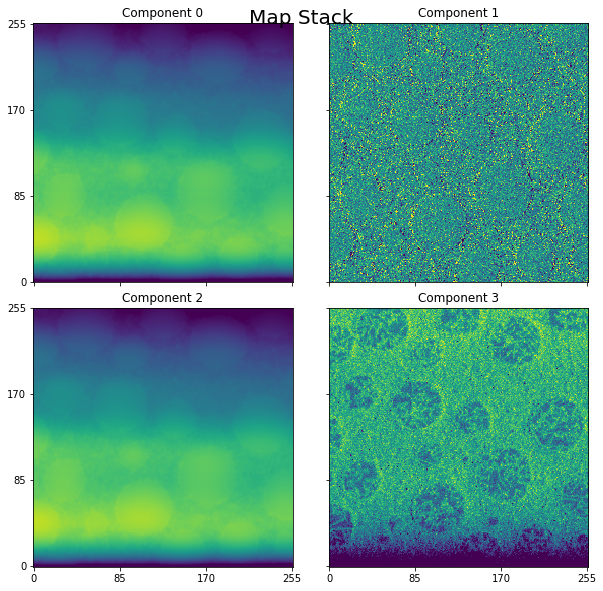

In [9]:
px.plot_utils.plot_map_stack(test.channel_data, reverse_dims=True);

## c. Write to h5 using the NumpyTranslator

Following step 4b here: https://pycroscopy.github.io/pyUSID/auto_examples/beginner/plot_numpy_translator.html

In [8]:
test.channel_data.shape

(256, 256, 4)

# Notes for Jess:

What you have are four `Channels` each of which are 2D images. These 2D images have 2 position dimensions and 1 spectroscopic dimension. The spectroscopic dimension is just a dummy dimension (you still need to have this).

The translator you want is very similar to the IgorPro translator available in pycroscopy. Just follow how that one is written and you should be fine.

I'll (quickly) show you how to translate this file below. Note that this is not a robust translation and needs to be a lot more robust. Nonetheless, these are the key steps. You can fill in the blanks yourself.

In [12]:
folder_path, file_name = os.path.split(orig_data_path)
h5_path = os.path.join(folder_path, file_name.replace('.txt', '.h5'))

In [23]:
h5_f = h5py.File(h5_path, mode='w')
usid.hdf_utils.write_book_keeping_attrs(h5_f)
h5_meas_grp = usid.hdf_utils.create_indexed_group(h5_f, 'Measurement_')
usid.hdf_utils.write_simple_attrs(h5_meas_grp, test.parms)

usid.hdf_utils.print_tree(h5_f)
map_stack = np.transpose(test.channel_data, axes=(2, 0, 1))


/
├ Measurement_000
  ---------------


Since all the channels share the same ancillary datasets, you might as well create them at the same level as the measurement group:

In [19]:
test.parms['XPhysUnit']

'µm'

In [24]:
# This remains the same - you gotr it right. I don't know how to handle non Unicode characters. 
# Maybe HDF5 cannot handle this at all
pos_dims = [usid.write_utils.Dimension('X', 'um', int(test.channel_data.shape[0])),
            usid.write_utils.Dimension('Y', 'um', int(test.channel_data.shape[1]))]
spec_dims = usid.write_utils.Dimension('arb', 'a.u.', values=1)

In [25]:
h5_pos_inds, h5_pos_vals = usid.hdf_utils.write_ind_val_dsets(h5_meas_grp, pos_dims, is_spectral=False)
h5_spec_inds, h5_spec_vals = usid.hdf_utils.write_ind_val_dsets(h5_meas_grp, spec_dims, is_spectral=True)

In [26]:
for img in map_stack:
    h5_chan_grp = usid.hdf_utils.create_indexed_group(h5_meas_grp, 'Channel_')
    h5_main = usid.hdf_utils.write_main_dataset(h5_chan_grp, img.reshape(-1, 1), 'Raw_Data', 
                                                'Quantity', 'Whatever units here', None, None, 
                                                h5_pos_inds=h5_pos_inds, h5_spec_inds=h5_spec_inds,
                                                h5_pos_vals=h5_pos_vals, h5_spec_vals=h5_spec_vals)
usid.hdf_utils.print_tree(h5_f)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Raw_Data
  ├ Channel_001
    -----------
    ├ Raw_Data
  ├ Channel_002
    -----------
    ├ Raw_Data
  ├ Channel_003
    -----------
    ├ Raw_Data
  ├ Position_Indices
  ├ Position_Values
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values


In [27]:
h5_f.close()

## d. Read data written to pycroscopy formatted h5 file

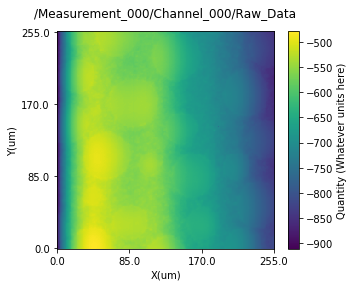

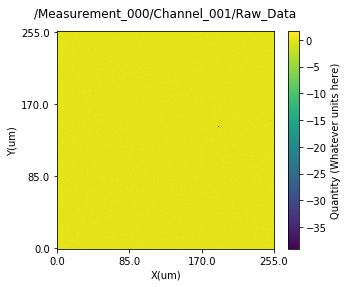

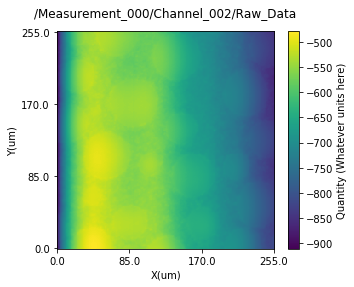

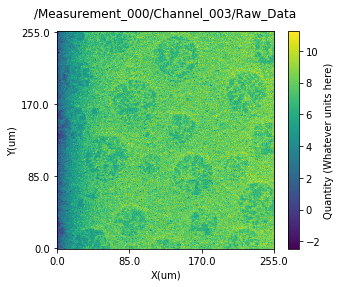

In [31]:
with h5py.File(h5_path, mode='r') as h5_f:
    for main_dset in usid.hdf_utils.get_all_main(h5_f):
        # print(main_dset)
        main_dset.visualize()